## Random Forest Modelling

### Import relevant libraries and dataset

In [198]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn import ensemble
from sklearn.metrics import RocCurveDisplay, roc_curve, auc
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.ensemble import AdaBoostClassifier

In [93]:
df = pd.read_csv('weatherAUS_imputed.csv')
df.head()

,Date,Location,Year,Month,RainToday,RainTomorrow,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindGustDir_angle,Latitude,Longitude,Cloud,Pressure,Temperature,Humidity,temp_fluctuation
0,2009-01-01,Cobar,2009,1,0.0,0.0,-0.254034,1.452543,1.231645,0.544048,0.367568,-0.016581,0.134517,-0.346762,-1.566909,1.483789,-2.239319,1.266185
1,2009-01-02,Cobar,2009,1,0.0,0.0,-0.254034,2.092290,1.417426,-0.274399,0.142577,-0.016581,0.134517,-1.337620,-0.534263,0.523016,-2.103988,-0.123978
2,2009-01-03,Cobar,2009,1,0.0,0.0,-0.254034,1.589632,1.497046,-0.795229,-0.307405,-0.016581,0.134517,-1.337620,-0.664246,1.892307,-2.753579,1.531952
3,2009-01-04,Cobar,2009,1,0.0,0.0,-0.254034,1.178365,0.780464,0.395239,-1.432358,-0.016581,0.134517,-0.346762,-0.787008,1.756134,-1.400263,1.450178
4,2009-01-05,Cobar,2009,1,0.0,0.0,-0.254034,1.315454,1.205105,-0.720824,1.267530,-0.016581,0.134517,-0.544934,-0.765344,1.839351,-1.535595,1.102637


In [135]:
#Before starting our modelling, we will define a ROC curve function to dipslay the results 
def roc_curve_custom(model, X, y):
    y_score = model.predict_proba(X)[:, 1] 
    fpr, tpr, _ = roc_curve(y, y_score)
    roc_auc = auc(fpr, tpr)
    
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='model')
    roc_display.plot(color='orange', label=f'clf model (auc = {np.round(roc_auc,2)})')
    plt.grid(True)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--',label='Random (auc = 0.5)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

### Random Forest

### 1. Without over or undersampling 

In [137]:
data = df.drop(columns=['RainTomorrow', 'RainToday', 'Location', 'Date'])
target = df['RainTomorrow']
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

In [138]:
clf = ensemble.RandomForestClassifier(n_jobs=-1, random_state=321)
clf.fit(X_train,y_train)

RandomForestClassifier(n_jobs=-1, random_state=321)

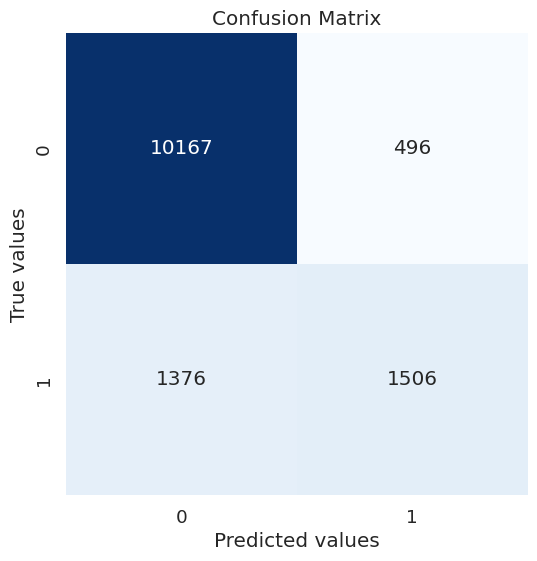

-------------------------
              precision    recall  f1-score   support

         0.0       0.88      0.95      0.92     10663
         1.0       0.75      0.52      0.62      2882

    accuracy                           0.86     13545
   macro avg       0.82      0.74      0.77     13545
weighted avg       0.85      0.86      0.85     13545

-------------------------
Model Accuracy Train Set: 1.0 Model Accuracy Test Set: 0.86


In [162]:
y_test_pred = clf.predict(X_test)
y_train_pred = clf.predict(X_train)
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale if needed
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, square=True)
plt.xlabel('Predicted values')
plt.ylabel('True values')
plt.title('Confusion Matrix')
plt.show()

# Generate classification report
report = classification_report(y_test, y_test_pred)

# Print the classification report
print('-------------------------')
print(report)

# Calculate accuracy for both sets
print('-------------------------')
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Model Accuracy Train Set:", train_accuracy, "Model Accuracy Test Set:", np.round(test_accuracy,2))

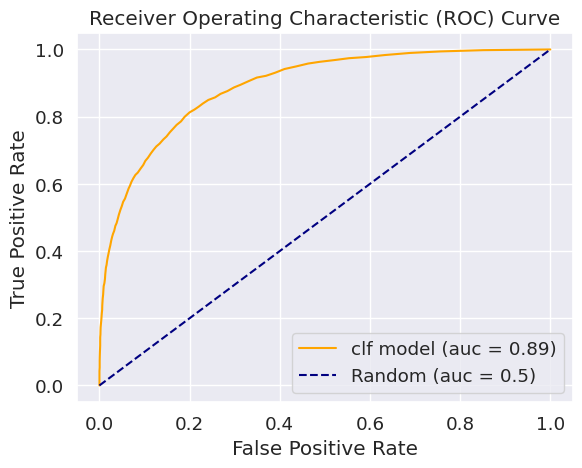

In [140]:
roc_curve_custom(clf, X_test, y_test)

AUC Value: An AUC value ranges from 0 to 1, where:

AUC = 1 implies a perfect classifier that perfectly separates positive and negative instances.
AUC = 0.5 implies a classifier that performs as good as random guessing.
AUC < 0.5 implies a classifier that performs worse than random guessing.

0.89 AUC: An AUC of 0.89 suggests that the model performs well across a wide range of thresholds. 

The model performs quite well for class 0, with high precision, recall, and F1-score, indicating that it's good at correctly identifying instances of class 0.

However, for class 1, the model's performance is relatively lower, especially in terms of recall (52%). This suggests that the model struggles more to correctly identify instances of class 1,which is likely linked to the imbalance in the dataset or a challenge in distinguishing class 1 instances from others.

The overall accuracy of the model is 86%, which is the proportion of correctly classified instances out of the total instances.

Since the dataset is very unbalanced, let's try with if we get better results with undersampling and oversampling.

### 2. Undersampling

In [141]:
from imblearn.under_sampling import RandomUnderSampler,  ClusterCentroids

### 2.1 Random Undersampling

In [183]:
rus = RandomUnderSampler()
sample_rus = rus.fit_resample(data,target)

In [184]:
X_train_rus, X_test_rus, y_train_rus, y_test_rus = train_test_split(sample_rus[0], sample_rus[1], test_size=0.2, random_state=42)

In [185]:
clf_rus = ensemble.RandomForestClassifier(n_jobs=-1, random_state=321)
clf_rus.fit(X_train_rus,y_train_rus)

RandomForestClassifier(n_jobs=-1, random_state=321)

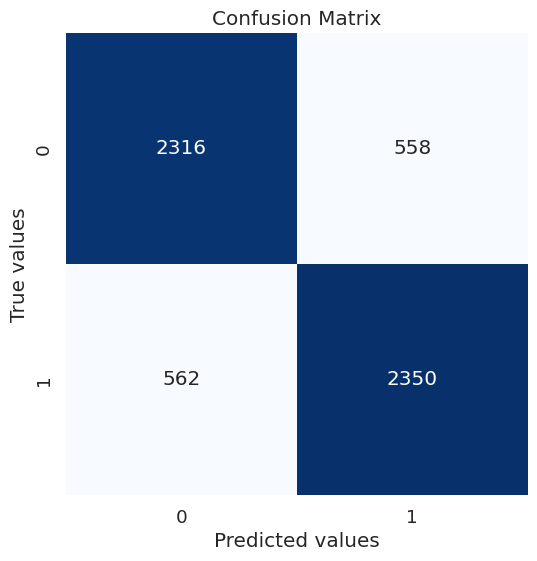

-------------------------
              precision    recall  f1-score   support

         0.0       0.80      0.81      0.81      2874
         1.0       0.81      0.81      0.81      2912

    accuracy                           0.81      5786
   macro avg       0.81      0.81      0.81      5786
weighted avg       0.81      0.81      0.81      5786

-------------------------
Accuracy Train Set: 1.0 Accuracy Test Set: 0.806


In [186]:
y_pred_rus= clf_rus.predict(X_test_rus)
y_pred_train_rus = clf_rus.predict(X_train_rus)
conf_matrix = confusion_matrix(y_test_rus, y_pred_rus)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale if needed
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, square=True)
plt.xlabel('Predicted values')
plt.ylabel('True values')
plt.title('Confusion Matrix')
plt.show()

# Generate classification report
report = classification_report(y_test_rus, y_pred_rus)

# Print the classification report
print('-------------------------')
print(report)

# Calculate accuracy for both sets
print('-------------------------')
train_accuracy = accuracy_score(y_train_rus, y_pred_train_rus)
test_accuracy = accuracy_score(y_test_rus, y_pred_rus)
print("Accuracy Train Set:", np.round(train_accuracy,3), "Accuracy Test Set:", np.round(test_accuracy,3))


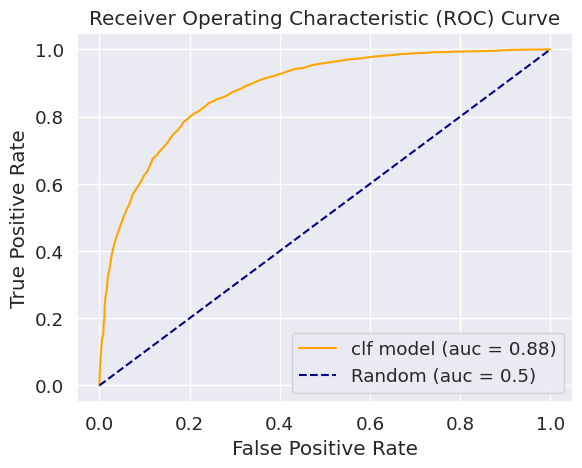

In [169]:
roc_curve_custom(clf_rus, X_test_rus, y_test_rus)

### 2.2 Cluster Centroids

In [187]:
cc = ClusterCentroids()
sample_cc = cc.fit_resample(data,target)

In [188]:
X_train_cc, X_test_cc, y_train_cc, y_test_cc = train_test_split(sample_cc[0], sample_cc[1], test_size=0.2, random_state=42)

In [189]:
clf_cc = ensemble.RandomForestClassifier(n_jobs=-1, random_state=321)
clf_cc.fit(X_train_cc,y_train_cc)

RandomForestClassifier(n_jobs=-1, random_state=321)

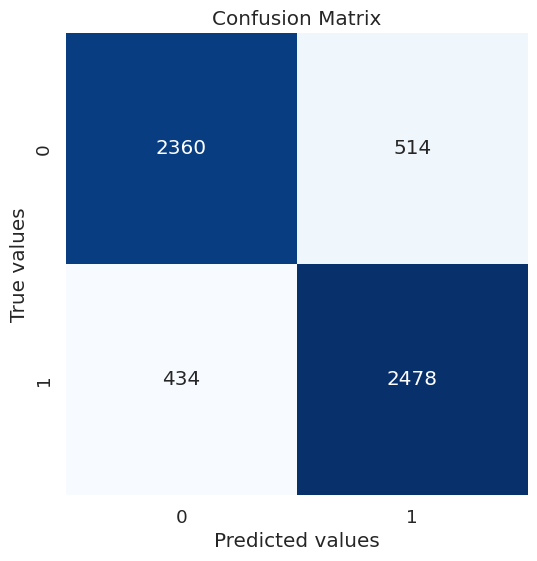

-------------------------
              precision    recall  f1-score   support

         0.0       0.84      0.82      0.83      2874
         1.0       0.83      0.85      0.84      2912

    accuracy                           0.84      5786
   macro avg       0.84      0.84      0.84      5786
weighted avg       0.84      0.84      0.84      5786

-------------------------
Accuracy Train Set: 1.0 Accuracy Test Set: 0.836


In [190]:
y_pred_cc = clf_cc.predict(X_test_cc)
y_pred_train_cc = clf_cc.predict(X_train_cc)
conf_matrix = confusion_matrix(y_test_cc, y_pred_cc)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale if needed
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, square=True)
plt.xlabel('Predicted values')
plt.ylabel('True values')
plt.title('Confusion Matrix')
plt.show()

# Generate classification report
report = classification_report(y_test_cc, y_pred_cc)

# Print the classification report
print('-------------------------')
print(report)

# Calculate accuracy for both sets
print('-------------------------')
train_accuracy = accuracy_score(y_train_cc, y_pred_train_cc)
test_accuracy = accuracy_score(y_test_cc, y_pred_cc)
print("Accuracy Train Set:", np.round(train_accuracy,3), "Accuracy Test Set:", np.round(test_accuracy,3))


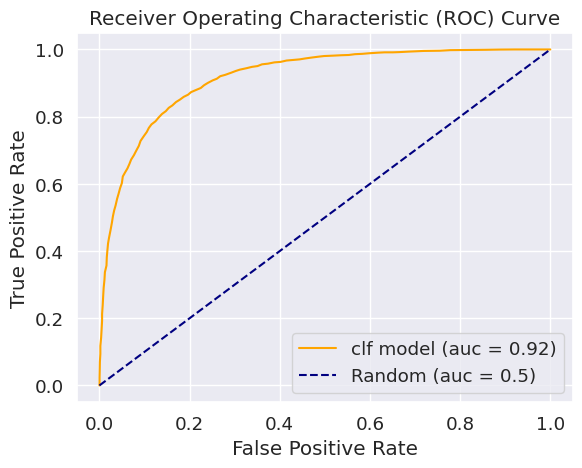

In [194]:
roc_curve_custom(clf_cc, X_test_cc, y_test_cc)

### 3. Oversampling

In [61]:
from imblearn.over_sampling import RandomOverSampler, SMOTE

### 3.1 Random Oversampling

In [62]:
ros = RandomOverSampler()
sample_ros = ros.fit_resample(data,target)

In [63]:
X_train_ros, X_test_ros, y_train_ros, y_test_ros = train_test_split(sample_ros[0], sample_ros[1], test_size=0.2, random_state=20)

In [64]:
clf_ros = ensemble.RandomForestClassifier(n_jobs=-1, random_state=321)
clf_ros.fit(X_train_ros,y_train_ros)

RandomForestClassifier(n_jobs=-1, random_state=321)

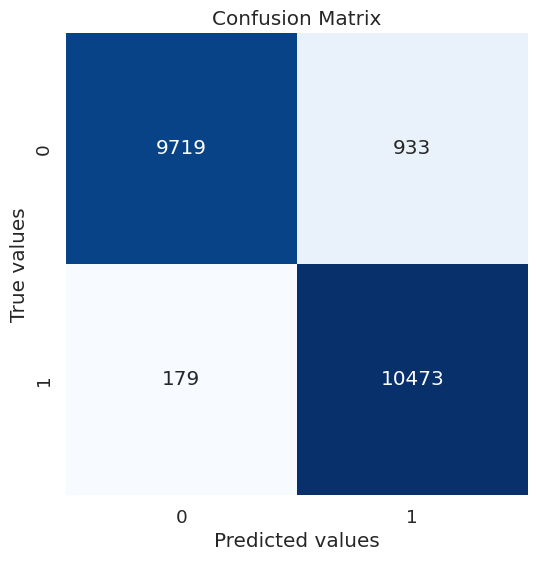

-------------------------
              precision    recall  f1-score   support

         0.0       0.98      0.91      0.95     10652
         1.0       0.92      0.98      0.95     10652

    accuracy                           0.95     21304
   macro avg       0.95      0.95      0.95     21304
weighted avg       0.95      0.95      0.95     21304

-------------------------
Accuracy Train Set: 1.0 Accuracy Test Set: 0.948


In [177]:
y_pred_ros = clf_ros.predict(X_test_ros)
y_pred_train_ros = clf_ros.predict(X_train_ros)
conf_matrix = confusion_matrix(y_test_ros, y_pred_ros)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale if needed
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, square=True)
plt.xlabel('Predicted values')
plt.ylabel('True values')
plt.title('Confusion Matrix')
plt.show()

# Generate classification report
report = classification_report(y_test_ros, y_pred_ros)

# Print the classification report
print('-------------------------')
print(report)

# Calculate accuracy for both sets
print('-------------------------')
train_accuracy = accuracy_score(y_train_ros, y_pred_train_ros)
test_accuracy = accuracy_score(y_test_ros, y_pred_ros)
print("Accuracy Train Set:", np.round(train_accuracy,3), "Accuracy Test Set:", np.round(test_accuracy,3))


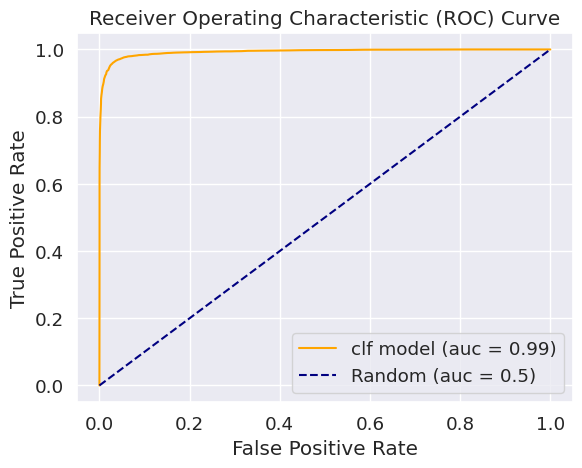

In [149]:
roc_curve_custom(clf_ros, X_test_ros, y_test_ros)

### 3.2. SMOTE 

In [50]:
smo = SMOTE()
sample_sm = smo.fit_resample(data,target)

In [51]:
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(sample_sm[0], sample_sm[1], test_size=0.2, random_state=20)

In [52]:
clf_sm = ensemble.RandomForestClassifier(n_jobs=-1, random_state=321)
clf_sm.fit(X_train_sm,y_train_sm)

RandomForestClassifier(n_jobs=-1, random_state=321)

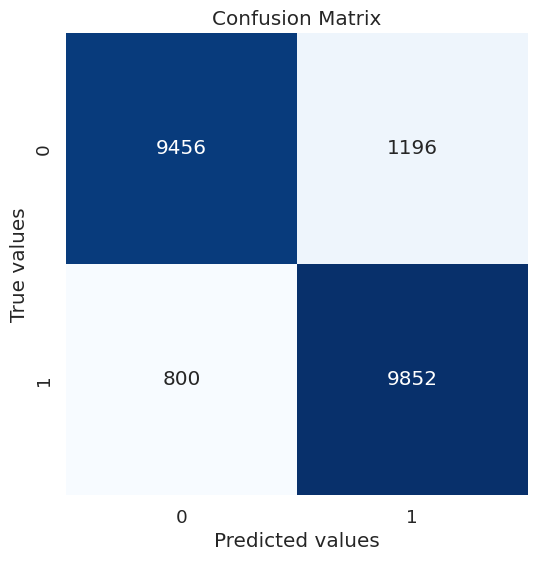

-------------------------
              precision    recall  f1-score   support

         0.0       0.92      0.89      0.90     10652
         1.0       0.89      0.92      0.91     10652

    accuracy                           0.91     21304
   macro avg       0.91      0.91      0.91     21304
weighted avg       0.91      0.91      0.91     21304

-------------------------
Accuracy Train Set: 1.0 Accuracy Test Set: 0.906


In [178]:
y_pred_sm = clf_sm.predict(X_test_sm)
y_pred_train_sm = clf_sm.predict(X_train_sm)
conf_matrix = confusion_matrix(y_test_sm, y_pred_sm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale if needed
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, square=True)
plt.xlabel('Predicted values')
plt.ylabel('True values')
plt.title('Confusion Matrix')
plt.show()

# Generate classification report
report = classification_report(y_test_sm, y_pred_sm)

# Print the classification report
print('-------------------------')
print(report)

# Calculate accuracy for both sets
print('-------------------------')
train_accuracy = accuracy_score(y_train_sm, y_pred_train_sm)
test_accuracy = accuracy_score(y_test_sm, y_pred_sm)
print("Accuracy Train Set:", np.round(train_accuracy,3), "Accuracy Test Set:", np.round(test_accuracy,3))

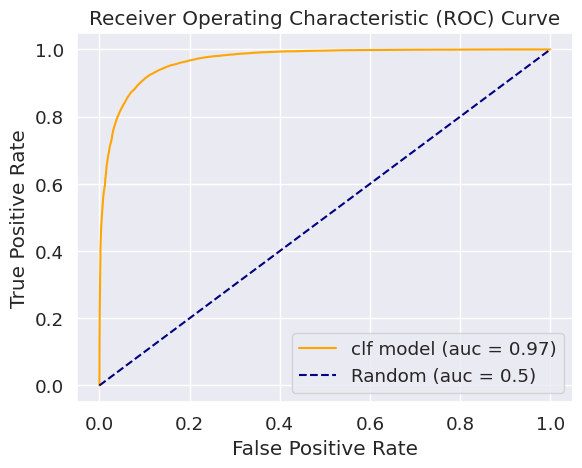

In [150]:
roc_curve_custom(clf_sm, X_test_sm, y_test_sm)

### 4. Conclusion Over/Undersampling

We get the best performance with the RandomOverSampler.

The model demonstrates excellent performance for both classes, with high precision, recall, and F1-score for both class 0 and class 1.

Class 0 has slightly higher precision, while class 1 has slightly higher recall, but their overall F1-scores are equal, indicating a balanced performance.

The overall accuracy of the model is 95%, indicating that it correctly predicts the class for 97% of the instances.

Both macro-average and weighted-average metrics are 95%, suggesting consistent and high-quality predictions across both individual classes and the entire dataset.

Let's see if we can get an even better result if we do some hyperparameter tuning with random_over_sampling. 

### 5. RandomOverSampler Hyperparameter Tuning 

### 5.1 GridSearchCV

In [74]:
clf_rf = ensemble.RandomForestClassifier(random_state=321)
"""
params = {'bootstrap': [True, False],
 'max_depth': [2,4],
 'max_features': ['auto', 'sqrt', 'log2'],
 'min_samples_leaf': range(1,10,1),
 'min_samples_split': range(2,10,1),
 'n_estimators': [10, 50, 100, 250, 500, 1000]}
"""
params = {'n_estimators': [10, 50, 100, 250],
          'min_samples_leaf': [1, 3, 5],
          'max_features': ['sqrt', 'log2']}
grid_cv1 = GridSearchCV(clf_rf, params, cv=3, refit=True)

In [75]:
fit1 = grid_cv1.fit(X_train_ros, y_train_ros)

In [77]:
from joblib import dump, load
dump(fit1, 'fit1.joblib')
fit_load1 = load('fit1.joblib')

In [78]:
fit_load1.best_params_

{'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 250}

In [79]:
params = {'n_estimators': [500, 1000],
          'min_samples_leaf': [1, 3, 5],
          'max_features': ['sqrt', 'auto']}
grid_cv2 = GridSearchCV(clf_rf, params, cv=3, refit=True)

In [80]:
fit2 = grid_cv2.fit(X_train_ros, y_train_ros)

/home/claudia/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/claudia/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/claudia/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it 

In [81]:
dump(fit2, 'fit2.joblib')
fit_load2 = load('fit2.joblib')

In [83]:
fit_load2.best_params_

{'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 1000}

### 5.2 Best Parameter Fit

In [193]:
clf = ensemble.RandomForestClassifier(n_jobs=-1, max_features='sqrt', min_samples_leaf=1, n_estimators=1000,random_state=321)
clf_best = clf.fit(X_train_ros,y_train_ros)

In [85]:
dump(clf_best, 'clf_best.joblib')
clf_best_load = load('clf_best.joblib')

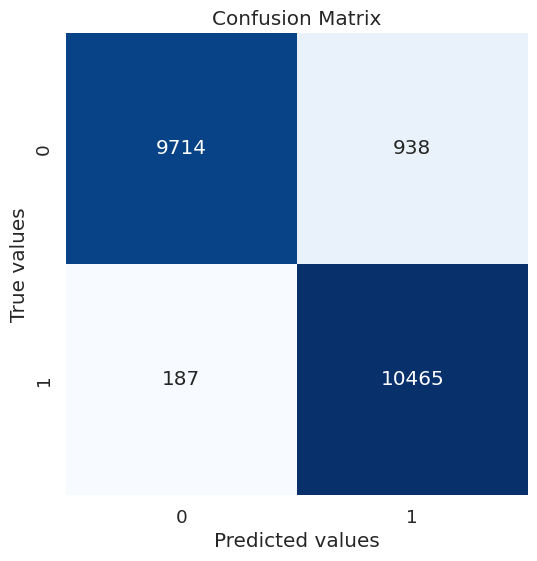

-------------------------
              precision    recall  f1-score   support

         0.0       0.98      0.91      0.95     10652
         1.0       0.92      0.98      0.95     10652

    accuracy                           0.95     21304
   macro avg       0.95      0.95      0.95     21304
weighted avg       0.95      0.95      0.95     21304

-------------------------
Accuracy Train Set: 1.0 Accuracy Test Set: 0.947


In [196]:
y_pred_best = clf_best_load.predict(X_test_ros)
y_pred_train_best = clf_best_load.predict(X_train_ros)
conf_matrix = confusion_matrix(y_test_ros, y_pred_best)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale if needed
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, square=True)
plt.xlabel('Predicted values')
plt.ylabel('True values')
plt.title('Confusion Matrix')
plt.show()

# Generate classification report
report = classification_report(y_test_ros, y_pred_best)

# Print the classification report
print('-------------------------')
print(report)

# Calculate accuracy for both sets
print('-------------------------')
train_accuracy = accuracy_score(y_train_ros, y_pred_train_best)
test_accuracy = accuracy_score(y_test_ros, y_pred_best)
print("Accuracy Train Set:", np.round(train_accuracy,3), "Accuracy Test Set:", np.round(test_accuracy,3))

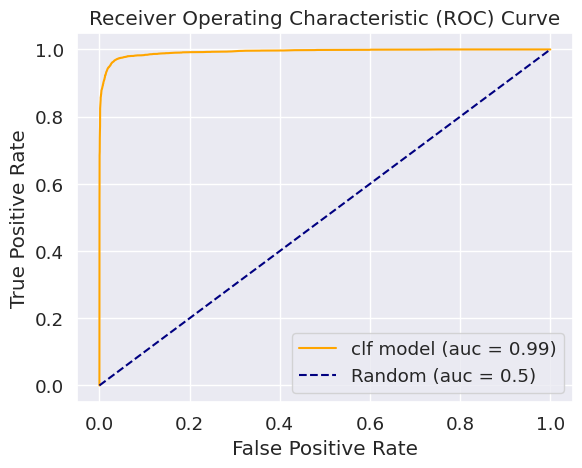

In [197]:
roc_curve_custom(clf_best, X_test_ros, y_test_ros)

Hyperparameter tuning didn't lead to a better result.

### 6. Boosting

In [199]:
ac = AdaBoostClassifier(base_estimator=clf_best_load,n_estimators=400)
ac.fit(X_train_ros,y_train_ros)

AdaBoostClassifier(base_estimator=RandomForestClassifier(n_estimators=1000,
                                                         n_jobs=-1,
                                                         random_state=321),
                   n_estimators=400)

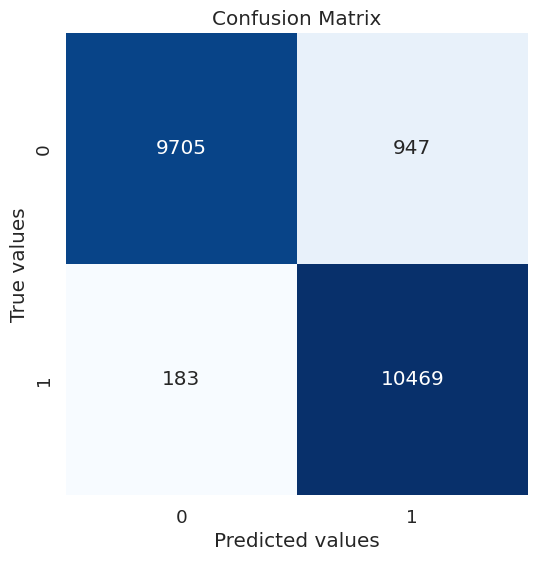

-------------------------
              precision    recall  f1-score   support

         0.0       0.98      0.91      0.94     10652
         1.0       0.92      0.98      0.95     10652

    accuracy                           0.95     21304
   macro avg       0.95      0.95      0.95     21304
weighted avg       0.95      0.95      0.95     21304

-------------------------
Accuracy Train Set: 1.0 Accuracy Test Set: 0.947


In [200]:
y_pred_ac = ac.predict(X_test_ros)
y_pred_train_ac = ac.predict(X_train_ros)
conf_matrix = confusion_matrix(y_test_ros, y_pred_ac)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale if needed
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, square=True)
plt.xlabel('Predicted values')
plt.ylabel('True values')
plt.title('Confusion Matrix')
plt.show()

# Generate classification report
report = classification_report(y_test_ros, y_pred_ac)

# Print the classification report
print('-------------------------')
print(report)

# Calculate accuracy for both sets
print('-------------------------')
train_accuracy = accuracy_score(y_train_ros, y_pred_train_ac)
test_accuracy = accuracy_score(y_test_ros, y_pred_best)
print("Accuracy Train Set:", np.round(train_accuracy,3), "Accuracy Test Set:", np.round(test_accuracy,3))

Applying boosting on top of the model did improve the accuracy of the model or the recall.

### 7. Feature Importance

Now that we figured out the best fitting model, let's have a look at the feature importance 

Feature ranking:
1. feature 4 (0.172702) - Sunshine
2. feature 12 (0.139200) - Humidity
3. feature 10 (0.098003) - Pressure
4. feature 13 (0.088355) - temp_fluctuation
5. feature 9 (0.087756) - Cloud
6. feature 5 (0.077018) - WindGustSpeed
7. feature 11 (0.061599) - Temperature
8. feature 3 (0.052035) - Evaporation
9. feature 2 (0.051775) - Rainfall
10. feature 6 (0.039435) - WindGustDir_angle
11. feature 8 (0.036464) - Longitude
12. feature 7 (0.033632) - Latitude
13. feature 1 (0.032174) - Month
14. feature 0 (0.029852) - Year


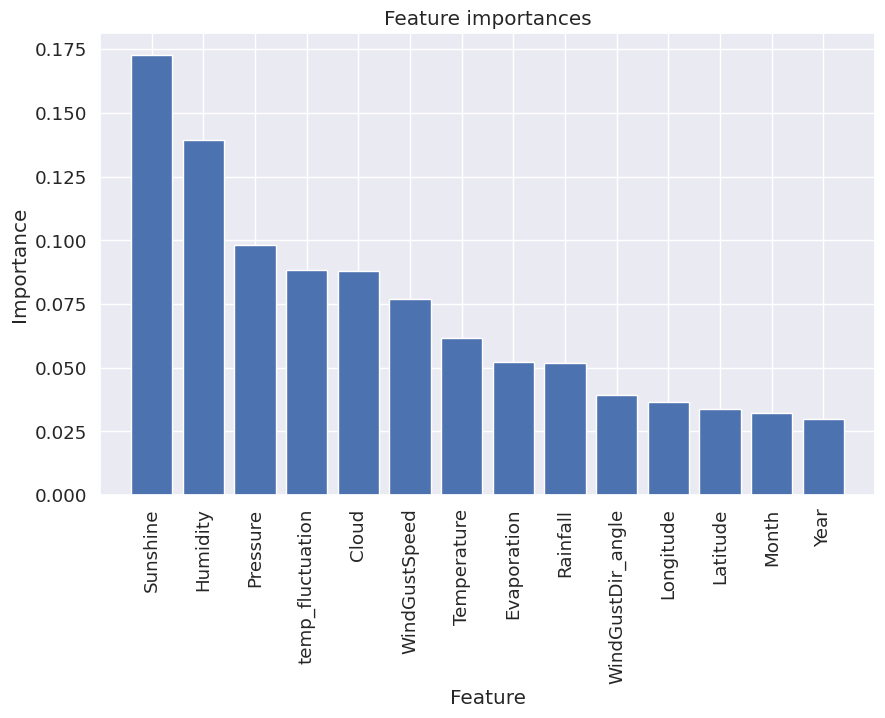

In [205]:
column_names= data.columns 
importances = clf_best.feature_importances_

# Get indices of features sorted by importance
indices = np.argsort(importances)[::-1]

# Print feature ranking
print("Feature ranking:")
for f in range(X_train_ros.shape[1]):
    print("%d. feature %d (%f) - %s" % (f + 1, indices[f], importances[indices[f]], column_names[indices[f]]))

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.bar(range(X_train_ros.shape[1]), importances[indices], color="b", align="center")
plt.xticks(range(X_train_ros.shape[1]), [column_names[i] for i in indices], rotation=90)
plt.xlim([-1, X_train_ros.shape[1]])
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()